In [1]:
import pandas as pd
from tqdm import tqdm

from tag_recommender.utils.text import to_snake_case_boosted

tqdm.pandas()

In [2]:
# read the tags from the train dataset
df = pd.read_parquet("../data/processed/train.parquet", columns=["root_tags", "tags"])

In [3]:
df.sample(10)

,root_tags,tags
287459,[],"[ty talks about tøp, silly little rambles of a..."
1375915,"[1899, 1899 netflix, 1899edit, maura franklin,...","[I will never forgive them for this, fuck netf..."
100441,"[pokemon, unreality, pkmn irl]","[pkmn irl, actually not sure this is that unpo..."
1076242,"[art, my art, digital art, drawing, fanart, il...",[the only human puss and boots ever]
816249,"[bocchi, bocchi the rock!]",[bocchi the rock!]
339834,[],[spongebob]
486487,[caplog 2022],[last night a German grandmother showed me pho...
1106960,[],[theres other reasons but thats what ive mainl...
340687,[],"[sims 4, black simblr, black simmer, simblr, l..."
531232,"[my art, undertale]","[so pretty, so good, undertale]"


In [4]:
# count each list in each row
df["root_tags_count"] = df["root_tags"].progress_apply(len)
df["tags_count"] = df["tags"].progress_apply(len)

# normalize the root tags
df["root_tags_norm"] = df["root_tags"].progress_apply(
    lambda arr: [to_snake_case_boosted(i) for i in arr]
)
# normalize the re-blogged tags
df["tags_norm"] = df["tags"].progress_apply(
    lambda arr: [to_snake_case_boosted(i) for i in arr]
)

# remove empty lists such as [""]
df["root_tags_norm"] = df["root_tags_norm"].progress_apply(
    lambda arr: [i for i in arr if i]
)
df["tags_norm"] = df["tags_norm"].progress_apply(lambda arr: [i for i in arr if i])

df.head()

100%|██████████| 1411621/1411621 [00:01<00:00, 1161189.60it/s]


,root_tags,tags,root_tags_count,tags_count,root_tags_norm,tags_norm
0,[],"[one piece, One piece japanese, one piece tran...",0,7,[],"[one_piece, one_piece_japanese, one_piece_tran..."
1,[],"[the outsiders, verse: the descent, work: the ...",0,4,[],"[the_outsiders, verse_the_descent, work_the_de..."
2,[],[my caps],0,1,[],[my_caps]
3,"[tw: food, the tiny dragon, the tiny dragon dr...","[feeling this post again lads and ladies, tw: ...",3,4,"[tw_food, the_tiny_dragon, the_tiny_dragon_draws]","[feeling_this_post_again_lads_and_ladies, tw_f..."
4,"[sad, sadness, sad qoutes, im not okay, im tir...","[study., queue.]",28,2,"[sad, sadness, sad_qoutes, im_not_okay, im_tir...","[study, queue]"


In [5]:
# Join all lists of tags in one place, to create a unified dataset
tags = pd.concat([df["root_tags_norm"], df["tags_norm"]]).to_frame()
tags.columns = ["tag_arrays"]
# filter out empty arrays
tags = tags[tags.tag_arrays.apply(len) > 0].copy()

del df

In [6]:
hashtags_counts = tags.tag_arrays.explode().value_counts()
hashtags_counts

tag_arrays
art                                                    89542
my_art                                                 62062
fanart                                                 43026
mine                                                   34344
pokemon                                                24959
                                                       ...  
i_woulr_scuff_and_crease_these_bad_boys_up_so_bad          1
dragondungeoning                                           1
more_people_know_gets_played_more_more_people_learn        1
which_turns_into_a_positive_feedback_loop                  1
gasp_its_a_baby                                            1
Name: count, Length: 1860177, dtype: int64

In [7]:
# Count how many tags appears once, two times, three times, etc
tags_buckets = hashtags_counts.value_counts().sort_index()
tags_buckets

count
1        1298719
2         200228
3          87656
4          52351
5          34294
          ...   
24959          1
34344          1
43026          1
62062          1
89542          1
Name: count, Length: 1795, dtype: int64

<Axes: ylabel='Frequency'>

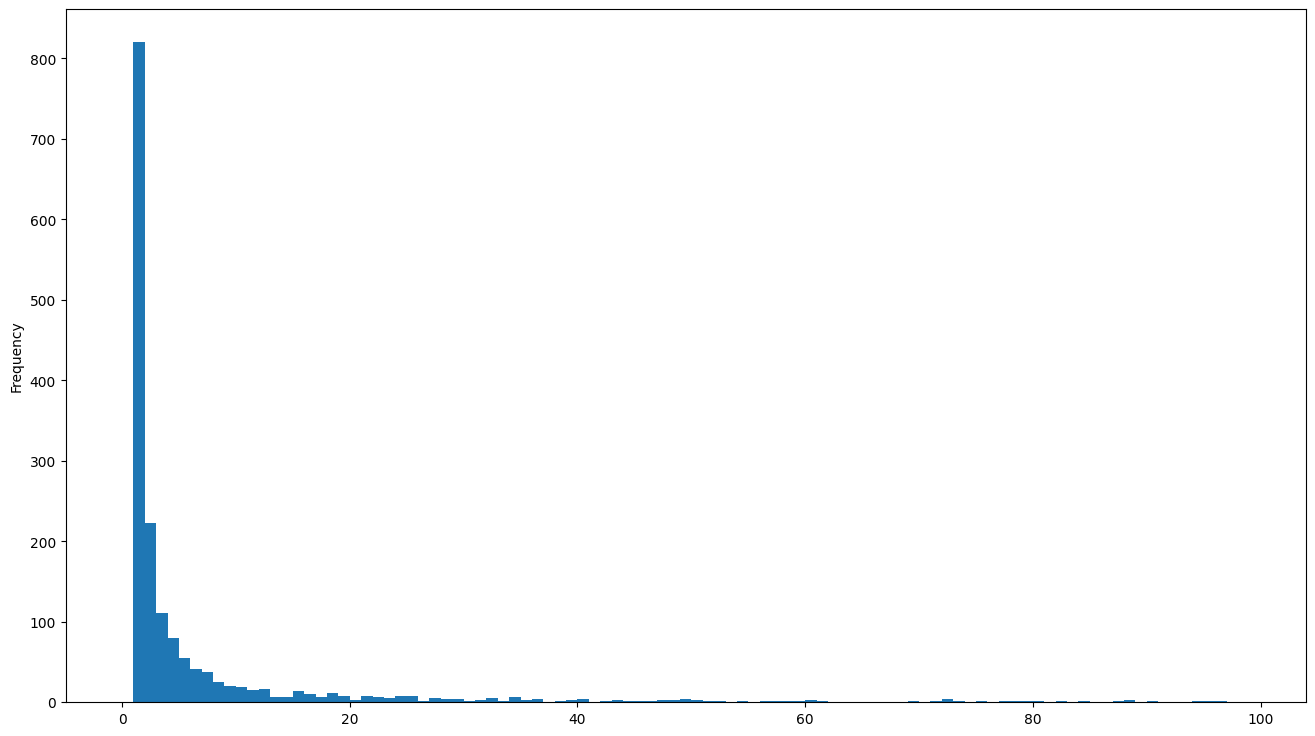

In [8]:
tags_buckets.plot(kind="hist", bins=range(100), figsize=(16, 9))

In [9]:
# Calculating the "total popularity count" for each tag array
tags["total_popularity"] = tags.tag_arrays.apply(
    lambda arr: sum([hashtags_counts[tag] for tag in arr])
)

In [10]:
tags.sort_values("total_popularity", ascending=False)

,tag_arrays,total_popularity
337965,"[gif, lol, fashion, art, vintage, illustration...",365002
1263316,"[sprigatito, pokemon, cat, artists_on_tumblr, ...",333999
169410,"[my_art, artists_on_tumblr, punch_out_carmen, ...",328456
1062118,"[lynx, cat, cats, animals, animal_art, animal,...",314715
250006,"[black_and_white, anime, concept_art, artwork,...",311197
...,...,...
180960,[please_god_may_the_dirt_and_clay_and_loam_swa...,1
180953,[tonight_i_choose_violence],1
713924,[footage_of_me_and_my_bf],1
1120614,[all_the_timmeeee],1


In [11]:
tags.sort_values("total_popularity", ascending=True).head(20)

,tag_arrays,total_popularity
635077,[once_a_gunner_etc],1
456815,[you_cant_start_a_fire_without_a_spark_memes],1
1165512,[bites_you_bites_you_bites_you_affectionate],1
885833,[these_remind_me_of_that_gif_set_someone_made_...,1
1165516,[i_can_hear_the_first_gif],1
1165520,[tri_linear_bitmap_interpolation],1
1165523,[we_are_a_family_in_traffic],1
25538,[suffer_first_and_enjoy_later_just_like_my_hyp...,1
276946,[hooooooly_fuck],1
456810,[red_makes_it_crunchy_imo],1


In [12]:
len(tags)

2332818

In [13]:
# Dropping all the tag arrays with popularity less than 20
tags = (
    tags[tags.total_popularity >= 20]
    .sort_values("total_popularity", ascending=False)
    .reset_index()
)
tags

,index,tag_arrays,total_popularity
0,337965,"[gif, lol, fashion, art, vintage, illustration...",365002
1,1263316,"[sprigatito, pokemon, cat, artists_on_tumblr, ...",333999
2,169410,"[my_art, artists_on_tumblr, punch_out_carmen, ...",328456
3,1062118,"[lynx, cat, cats, animals, animal_art, animal,...",314715
4,250006,"[black_and_white, anime, concept_art, artwork,...",311197
...,...,...,...
1956179,763422,[i_love_being_drunk_bc_it_makes_me_not_worry_s...,20
1956180,806904,[haibane_renmei],20
1956181,763502,"[baph_bleats, radfem_cope, pro_kink, kink_educ...",20
1956182,1392477,[khan],20


In [14]:
len(tags)

1956184

In [15]:
# Testing the procedure with a sample, because the library can't hanlde many data.
# This pipeline will be also implemented using pyspark.
tags_sample = tags.tag_arrays.head(100_000)
tags_sample

0        [gif, lol, fashion, art, vintage, illustration...
1        [sprigatito, pokemon, cat, artists_on_tumblr, ...
2        [my_art, artists_on_tumblr, punch_out_carmen, ...
3        [lynx, cat, cats, animals, animal_art, animal,...
4        [black_and_white, anime, concept_art, artwork,...
                               ...                        
99995    [art, lore_vibes_i_associate_pirate_lesbians_w...
99996                           [art, also_me_the_girlies]
99997             [art, istg_if_this_gets_flagged_ill_cry]
99998                              [to_be_deciphered, art]
99999    [art, the_tiny_part_of_me_that_enjoyed_taking_...
Name: tag_arrays, Length: 100000, dtype: object

In [16]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

te = TransactionEncoder()
te_ary = te.fit(tags_sample).transform(tags_sample)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,0,00,000,0000,0000art,002,007,007_q,008,00_q,...,黒崎,黒崎一護,黒猫,黒髪ロンク,龍,龍か如く,ꈍᴗꈍ,𑁤_𓈊_𖧷_new_post,𓇼_白鳥我的愛重さの,𖥻_princess
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99996,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99997,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
99998,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [17]:
# each item (tag) must exist at least 200 times
support = 200

support_prc = support / len(df)
support_prc

0.002

In [18]:
frequent_itemsets = fpgrowth(df, min_support=support_prc, use_colnames=True)
frequent_itemsets

,support,itemsets
0,0.76220,(art)
1,0.12443,(illustration)
2,0.04811,(lol)
3,0.04378,(cute)
4,0.04208,(animals)
...,...,...
120202,0.00313,"(im_almost_done_w_the_manga_by_the_way, art)"
120203,0.00313,"(mp_100, im_almost_done_w_the_manga_by_the_way..."
120204,0.00313,"(im_almost_done_w_the_manga_by_the_way, rr_por..."
120205,0.00313,"(mp_100, im_almost_done_w_the_manga_by_the_way..."


In [19]:
from mlxtend.frequent_patterns import association_rules

# We want the lift to be > 1.
# lift = confidence / expected_confidence
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
23322829,"(meme, kittens, pet, humor, animal, funny)","(cat, haha, memes, lol, animals, pets)",0.00227,0.00304,0.00227,1.000000,328.947368,0.002263,inf,0.999228,6
26279969,"(memes, cute_animals, kitty, pet, funny)","(haha, lol, baby_animals, animals, animal, pets)",0.00203,0.00295,0.00203,1.000000,338.983051,0.002024,inf,0.999078,5
26279973,"(memes, cute_animals, pet, funny, pets)","(haha, lol, baby_animals, animals, kitty, animal)",0.00203,0.00340,0.00203,1.000000,294.117647,0.002023,inf,0.998627,5
26279976,"(memes, cute_animals, kitty, funny, pets)","(haha, lol, baby_animals, animals, pet, animal)",0.00203,0.00295,0.00203,1.000000,338.983051,0.002024,inf,0.999078,5
26279977,"(memes, cute_animals, animal, funny, pets)","(haha, lol, baby_animals, animals, pet, kitty)",0.00203,0.00266,0.00203,1.000000,375.939850,0.002025,inf,0.999369,5
...,...,...,...,...,...,...,...,...,...,...,...
260465,(art),"(drawing, illustration, digital_art, clip_stud...",0.76220,0.00211,0.00200,0.002624,1.243594,0.000392,1.000515,0.823713,1
5777,(art),"(digital_painting, digital_art, painting)",0.76220,0.00205,0.00200,0.002624,1.279992,0.000437,1.000575,0.919870,1
21755,(art),"(drawing, character_design, illustration, digi...",0.76220,0.00213,0.00200,0.002624,1.231917,0.000377,1.000495,0.791661,1
260933,(art),"(illustration, ink, artists_on_tumblr)",0.76220,0.00203,0.00200,0.002624,1.292603,0.000453,1.000596,0.951922,1


In [20]:
rules[rules.antecedent_len == 1].sort_values("confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
43324111,(catasters),"(animals, meow)",0.00695,0.00721,0.00695,1.000000,138.696255,0.006900,inf,0.999738,1
43296567,(death_i_would_die_for_you_i_wouldnt_have_a_ch...,"(my_art, puss_in_boots_wolf, puss_in_boots_the...",0.00211,0.00229,0.00211,1.000000,436.681223,0.002105,inf,0.999820,1
43306821,(everythingfox),"(lol, funny, animals)",0.00880,0.02729,0.00880,1.000000,36.643459,0.008560,inf,0.981346,1
43326905,(catasters),"(cats, cat, funny, cute)",0.00695,0.01914,0.00695,1.000000,52.246604,0.006817,inf,0.987725,1
43306526,(everythingfox),"(cat, wholesome, cute)",0.00880,0.01365,0.00880,1.000000,73.260073,0.008680,inf,0.995107,1
...,...,...,...,...,...,...,...,...,...,...,...
260021,(art),"(style, beauty)",0.76220,0.00207,0.00200,0.002624,1.267625,0.000422,1.000555,0.887817,1
260933,(art),"(illustration, ink, artists_on_tumblr)",0.76220,0.00203,0.00200,0.002624,1.292603,0.000453,1.000596,0.951922,1
21755,(art),"(drawing, character_design, illustration, digi...",0.76220,0.00213,0.00200,0.002624,1.231917,0.000377,1.000495,0.791661,1
260465,(art),"(drawing, illustration, digital_art, clip_stud...",0.76220,0.00211,0.00200,0.002624,1.243594,0.000392,1.000515,0.823713,1


In [21]:
rules[rules.antecedent_len == 1].sort_values("support", ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,antecedent_len
3940,(my_art),(fanart),0.20807,0.18389,0.10225,0.491421,2.672365,0.063988,1.604687,0.790221,1
3941,(fanart),(my_art),0.18389,0.20807,0.10225,0.556039,2.672365,0.063988,1.783783,0.766808,1
1301,(digital_art),(my_art),0.15506,0.20807,0.07186,0.463434,2.227296,0.039597,1.475921,0.652147,1
1300,(my_art),(digital_art),0.20807,0.15506,0.07186,0.345365,2.227296,0.039597,1.290703,0.695800,1
1303,(fanart),(digital_art),0.18389,0.15506,0.05667,0.308173,1.987446,0.028156,1.221318,0.608793,1
1302,(digital_art),(fanart),0.15506,0.18389,0.05667,0.365471,1.987446,0.028156,1.286167,0.588020,1
1329,(artists_on_tumblr),(digital_art),0.12054,0.15506,0.05545,0.460013,2.966679,0.036759,1.564742,0.753784,1
1328,(digital_art),(artists_on_tumblr),0.15506,0.12054,0.05545,0.357604,2.966679,0.036759,1.369030,0.784580,1
1,(digital_art),(illustration),0.15506,0.12443,0.05472,0.352896,2.836098,0.035426,1.353058,0.766212,1
0,(illustration),(digital_art),0.12443,0.15506,0.05472,0.439765,2.836098,0.035426,1.508189,0.739407,1


In [25]:
rules.to_pickle("../artifacts/models/association_rules.pickle")